In [ ]:
!git clone https://github.com/facebookresearch/CrypTen.git

In [ ]:
%cd CrypTen

In [ ]:
!sed -i 's/sklearn/scikit-learn/g' requirements.txt

In [ ]:
!pip install -e .

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

import crypten
import crypten.mpc as mpc

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

/content/CrypTen/crypten/nn/module.py:1880: SyntaxWarning: invalid escape sequence '\_'
  additional dimensions and :math:`H_{in} = \text{in\_features}`


In [ ]:
FEATURE_COLS_FHE = [
    'From Bank', 'To Bank', 'Amount Received', 'Amount Paid',
    'Hour', 'DayOfWeek', 'Month', 'Day', 'IsWeekend', 'IsNightTime',
    'Same_Bank', 'Same_Account', 'Same_Entity',
    'Amount_Difference', 'Log_Amount_Received', 'Log_Amount_Paid',
    'Round_Amount_Received', 'Round_Amount_Paid', 'Below_Threshold',
    'Currency_Mismatch', 'Payment Format_Encoded',
    'Receiving Currency_Encoded', 'Payment Currency_Encoded',
    'Bank_Partition'
]

In [ ]:
def preprocess_fhe_style(df: pd.DataFrame) -> pd.DataFrame:

    print(">> Running CPU preprocessing (FHE-style)...")

    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y/%m/%d %H:%M', errors='coerce')
    df['Hour'] = df['Timestamp'].dt.hour.fillna(0).astype(int)
    df['DayOfWeek'] = df['Timestamp'].dt.weekday.fillna(0).astype(int)
    df['Month'] = df['Timestamp'].dt.month.fillna(0).astype(int)
    df['Day'] = df['Timestamp'].dt.day.fillna(0).astype(int)

    df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype('int32')
    df['IsNightTime'] = ((df['Hour'] >= 22) | (df['Hour'] <= 6)).astype('int32')

    df['Same_Bank'] = (df['From Bank'] == df['To Bank']).astype('int32')
    df['Same_Account'] = (df['From_Account'] == df['To_Account']).astype('int32')
    df['Same_Entity'] = (df['Sender_Entity ID'] == df['Receiver_Entity ID']).astype('int32')

    df['Amount Received'] = pd.to_numeric(df['Amount Received'], errors='coerce').fillna(0.0)
    df['Amount Paid'] = pd.to_numeric(df['Amount Paid'], errors='coerce').fillna(0.0)

    df['Log_Amount_Received'] = np.log1p(df['Amount Received'].astype(float))
    df['Log_Amount_Paid'] = np.log1p(df['Amount Paid'].astype(float))
    df['Amount_Difference'] = (df['Amount Received'] - df['Amount Paid']).abs()

    df['Round_Amount_Received'] = ((df['Amount Received'] % 1000) == 0).astype('int32')
    df['Round_Amount_Paid'] = ((df['Amount Paid'] % 1000) == 0).astype('int32')
    df['Below_Threshold'] = ((df['Amount Received'] > 9000) & (df['Amount Received'] < 10000)).astype('int32')

    df['Currency_Mismatch'] = (df['Receiving Currency'] != df['Payment Currency']).astype('int32')

    categorical_cols = ['Payment Format', 'Receiving Currency', 'Payment Currency']
    for col in categorical_cols:
        df[col] = df[col].fillna('___MISSING___').astype(str)
        df[f'{col}_Encoded'] = df[col].astype('category').cat.codes

    if 'Bank_Partition' not in df.columns:
        unique_banks = pd.Series(df['From Bank'].unique()).astype(str).sort_values().reset_index(drop=True)
        bank_map = {b: i for i, b in enumerate(unique_banks)}
        df['Bank_Partition'] = df['From Bank'].astype(str).map(bank_map).fillna(0).astype(int)

    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=['Unnamed: 0'])

    df = df.drop(columns=['Unnamed: 0.1'])

    print(">> CPU preprocessing done. Final columns:", list(df.columns))
    return df

In [ ]:
def load_all_bank_data():
    """Load all bank datasets from the provided structure"""
    path = "/content/drive/MyDrive/cleaned_data_json"

    files = os.listdir(path)

    all_dfs = []

    for bank_id, file in enumerate(files):
        file_path = os.path.join(path, file)
        try:
            df = pd.read_json(file_path)
            df['source_bank'] = bank_id
            all_dfs.append(df)
            print(f"Loaded {file_path}")
        except FileNotFoundError:
            print(f"File not found: {file_path}")
            continue
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            continue

    if not all_dfs:
        raise ValueError("No bank data files were successfully loaded!")

    combined_df = pd.concat(all_dfs, ignore_index=True)

    final_df = pd.concat([
        combined_df[['bank_id', 'source_bank', 'source_folder']],
        pd.json_normalize(combined_df['records'])
    ], axis=1)

    print(f"Total records loaded: {len(final_df)}")
    return final_df

In [ ]:
final_df = load_all_bank_data()

In [ ]:
class FraudDetectionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, max(16, hidden_dim // 2)),
            nn.ReLU(),
            nn.Linear(max(16, hidden_dim // 2), 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

def evaluate_model_numpy(model, X, y):
    model.eval()
    with torch.no_grad():
        preds = model(torch.tensor(X, dtype=torch.float32))
        pred_labels = (preds.cpu().numpy() > 0.5).astype(int)
    return {
        'accuracy': accuracy_score(y, pred_labels),
        'precision': precision_score(y, pred_labels, zero_division=0),
        'recall': recall_score(y, pred_labels, zero_division=0),
        'f1': f1_score(y, pred_labels, zero_division=0)
    }


In [ ]:
df = pd.read_csv("/content/balance_full.csv")
df_p = preprocess_fhe_style(df.copy())

missing_cols = [c for c in FEATURE_COLS_FHE if c not in df_p.columns]
if missing_cols:
  raise ValueError(f"Missing required FHE feature columns after preprocessing: {missing_cols}")


>> Running CPU preprocessing (FHE-style)...
>> CPU preprocessing done. Final columns: ['bank_id', 'Timestamp', 'From Bank', 'From_Account', 'To Bank', 'To_Account', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering', 'Sender_Bank Name', 'Sender_Bank ID', 'Sender_Entity ID', 'Sender_Entity Name', 'Receiver_Bank Name', 'Receiver_Bank ID', 'Receiver_Entity ID', 'Receiver_Entity Name', 'Bank_Partition', 'Hour', 'DayOfWeek', 'Month', 'Day', 'IsWeekend', 'IsNightTime', 'Same_Bank', 'Same_Account', 'Same_Entity', 'Log_Amount_Received', 'Log_Amount_Paid', 'Amount_Difference', 'Round_Amount_Received', 'Round_Amount_Paid', 'Below_Threshold', 'Currency_Mismatch', 'Payment Format_Encoded', 'Receiving Currency_Encoded', 'Payment Currency_Encoded']


In [ ]:
def run_encrypted_fhe_aligned_training(
    df,
    use_gpu_preprocessing=False,
    num_rounds=10,
    local_epochs=2,
    lr=0.01,
    batch_size=32,
    test_frac=0.2,
    save_model_path=None
):

    missing_cols = [c for c in FEATURE_COLS_FHE if c not in df_p.columns]
    if missing_cols:
        raise ValueError(f"Missing required FHE feature columns after preprocessing: {missing_cols}")

    rng = np.random.RandomState(42)
    mask = rng.rand(len(df_p)) < test_frac
    test_df = df_p[mask].reset_index(drop=True)
    train_df = df_p[~mask].reset_index(drop=True)

    X_test = test_df[FEATURE_COLS_FHE].astype(np.float32).values
    y_test = test_df['Is Laundering'].astype(int).values

    bank_groups = train_df.groupby('Bank_Partition')
    bank_data = {}
    for bank_id, group in bank_groups:
        Xb = group[FEATURE_COLS_FHE].astype(np.float32).values
        yb = group['Is Laundering'].astype(int).values
        if len(Xb) == 0:
            continue
        bank_data[int(bank_id)] = {'X': Xb, 'y': yb}

    if len(bank_data) == 0:
        raise ValueError("No bank partitions with training data found.")

    input_dim = len(FEATURE_COLS_FHE)
    global_model = FraudDetectionModel(input_dim)

    crypten.init()

    metrics = {'round': [], 'accuracy': [], 'f1': [], 'comm_kb': [], 'latency_s': []}

    for rnd in range(1, num_rounds + 1):
        start_time = time.time()
        encrypted_updates = []
        comm_bytes = 0

        participating = list(bank_data.keys())

        for bank_id in participating:
            local_model = FraudDetectionModel(input_dim)
            local_model.load_state_dict(global_model.state_dict())
            opt = optim.SGD(local_model.parameters(), lr=lr)
            loss_fn = nn.BCELoss()

            Xb = bank_data[bank_id]['X']
            yb = bank_data[bank_id]['y']
            local_model.train()
            for epoch in range(local_epochs):
                perm = np.random.permutation(len(Xb))
                for i in range(0, len(perm), batch_size):
                    idx = perm[i:i + batch_size]
                    bx = torch.tensor(Xb[idx], dtype=torch.float32)
                    by = torch.tensor(yb[idx], dtype=torch.float32)
                    opt.zero_grad()
                    preds = local_model(bx)
                    loss = loss_fn(preds, by)
                    loss.backward()
                    opt.step()

            local_update_enc = []
            for lp, gp in zip(local_model.parameters(), global_model.parameters()):
                upd = lp.data - gp.data
                enc = crypten.cryptensor(upd)
                local_update_enc.append(enc)
                comm_bytes += enc.element_size() * enc.numel() if hasattr(enc, 'element_size') else upd.nelement() * 8

            encrypted_updates.append(local_update_enc)

        agg_updates = []
        for param_idx in range(len(encrypted_updates[0])):
            s = encrypted_updates[0][param_idx]
            for j in range(1, len(encrypted_updates)):
                s = s + encrypted_updates[j][param_idx]
            agg_updates.append(s / len(encrypted_updates))

        with torch.no_grad():
            for param, enc_upd in zip(global_model.parameters(), agg_updates):
                plain = enc_upd.get_plain_text()
                param.data += lr * plain

        eval_res = evaluate_model_numpy(global_model, X_test, y_test)
        latency = time.time() - start_time

        metrics['round'].append(rnd)
        metrics['accuracy'].append(eval_res['accuracy'])
        metrics['f1'].append(eval_res['f1'])
        metrics['comm_kb'].append(comm_bytes / 1024.0)
        metrics['latency_s'].append(latency)

        print(f"[Round {rnd}/{num_rounds}] acc={eval_res['accuracy']:.4f} f1={eval_res['f1']:.4f} comm={comm_bytes/1024:.1f}KB time={latency:.2f}s")

    if save_model_path:
        torch.save(global_model.state_dict(), save_model_path)
        print(f"Saved global model state_dict to {save_model_path}")

    return metrics, global_model

In [ ]:
def select_model_pipeline(df: pd.DataFrame, verbose=True):
    n_rows, n_cols = df.shape
    banks = df['From Bank'].nunique() if 'From Bank' in df.columns else 0
    currencies = (
        len(set(df.get('Receiving Currency', [])) | set(df.get('Payment Currency', [])))
        if 'Receiving Currency' in df.columns else 0
    )
    avg_amount = df['Amount Received'].mean() if 'Amount Received' in df.columns else 0
    std_amount = df['Amount Received'].std() if 'Amount Received' in df.columns else 0

    engineered_features = [c for c in df.columns if '_Encoded' in c or c.startswith(('Log_', 'Round_', 'Same_'))]
    feature_richness = len(engineered_features)

    sensitive_cols = [c for c in df.columns if any(x in c.lower() for x in ['account', 'entity', 'bank id', 'name'])]
    has_sensitive = len(sensitive_cols) > 0

    scores = {"fhe": 0, "mpc": 0, "plain_ml": 0, "plain_dl": 0}

    if has_sensitive:
        scores["fhe"] += 30
        scores["mpc"] += 15
    else:
        scores["plain_ml"] += 10

    if n_rows < 5_000:
        scores["plain_ml"] += 25
    elif n_rows < 50_000:
        scores["mpc"] += 8
        scores["plain_ml"] += 10
    else:
        scores["plain_dl"] += 25
        scores["mpc"] += 5

    if banks <= 1:
        scores["plain_ml"] += 10
    elif 2 <= banks <= 5:
        scores["mpc"] += 15
    elif banks > 5:
        scores["mpc"] += 15
        scores["fhe"] += 5

    if currencies > 3:
        scores["mpc"] += 6
        scores["fhe"] += 7

    if std_amount > avg_amount * 2:
        scores["plain_dl"] += 10
    elif std_amount < avg_amount * 0.5:
        scores["plain_ml"] += 5

    if feature_richness > 15:
        scores["plain_dl"] += 10
    elif feature_richness < 10:
        scores["plain_ml"] += 5
    else:
        scores["mpc"] += 3

    recommended = max(scores, key=scores.get)

    reasons = {
        "fhe": "High data sensitivity and encryption need → FHE preferred.",
        "mpc": "Data distributed across multiple banks/institutions → MPC recommended.",
        "plain_ml": "Centralized and relatively small dataset → Plain ML is efficient.",
        "plain_dl": "Large, complex dataset with many features → Deep Learning suitable."
    }

    if verbose:
        print("========== MODEL PIPELINE RECOMMENDATION ==========")
        print(f"Rows: {n_rows:,}, Columns: {n_cols}")
        print(f"Unique banks: {banks}, Currencies: {currencies}")
        print(f"Avg Amount: {avg_amount:,.2f}, StdDev: {std_amount:,.2f}")
        print(f"Feature richness: {feature_richness}, Sensitive cols: {len(sensitive_cols)}")
        print("\nScore breakdown:")
        for k, v in scores.items():
            print(f"  {k:10s} → {v}")
        print(f"\nRecommended Pipeline: {recommended.upper()}  |  Reason: {reasons[recommended]}")
        print("===================================================")

    return {"recommended": recommended, "scores": scores, "reason": reasons[recommended]}



In [ ]:
metrics, model = run_encrypted_fhe_aligned_training(df_p)

/content/CrypTen/crypten/__init__.py:64: RuntimeWarning: CrypTen is already initialized.
  warnings.warn("CrypTen is already initialized.", RuntimeWarning)


[Round 1/10] acc=0.6671 f1=0.2595 comm=290.1KB time=0.73s
[Round 2/10] acc=0.5258 f1=0.4264 comm=290.1KB time=0.73s
[Round 3/10] acc=0.3342 f1=0.4357 comm=290.1KB time=0.71s
[Round 4/10] acc=0.3654 f1=0.4378 comm=290.1KB time=0.72s
[Round 5/10] acc=0.3521 f1=0.4417 comm=290.1KB time=0.69s
[Round 6/10] acc=0.4088 f1=0.4335 comm=290.1KB time=0.69s
[Round 7/10] acc=0.5633 f1=0.3949 comm=290.1KB time=0.71s
[Round 8/10] acc=0.5650 f1=0.3965 comm=290.1KB time=0.69s
[Round 9/10] acc=0.3946 f1=0.4699 comm=290.1KB time=0.69s
[Round 10/10] acc=0.4775 f1=0.4691 comm=290.1KB time=0.70s


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def predict_and_plot_matrix(sample_df, model, feature_cols):

    print(">> Running CPU preprocessing (FHE-style)...")
    processed_df = preprocess_fhe_style(sample_df.copy())
    print(">> CPU preprocessing done.")
    print(">> Preprocessing done. Final columns:", list(processed_df.columns))

    missing_cols = [c for c in feature_cols if c not in processed_df.columns]
    if missing_cols:
        print(f"Warning: Missing required feature columns after preprocessing: {missing_cols}")
        available_features = [c for c in feature_cols if c in processed_df.columns]
        if not available_features:
             raise ValueError("No feature columns available after preprocessing.")
        print(f"Using available features: {available_features}")
        X_sample = processed_df[available_features].astype(np.float32).values
    else:
      X_sample = processed_df[feature_cols].astype(np.float32).values

    if 'Is Laundering' not in processed_df.columns:
        print("Warning: 'Is Laundering' column not found in processed data. Cannot plot confusion matrix or calculate metrics.")
        y_sample = None
    else:
        y_sample = processed_df['Is Laundering'].astype(int).values

    model.eval()
    with torch.no_grad():
        preds = model(torch.tensor(X_sample, dtype=torch.float32))
        pred_labels = (preds.cpu().numpy() > 0.5).astype(int)

    if y_sample is not None:
        cm = confusion_matrix(y_sample, pred_labels)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

        accuracy = accuracy_score(y_sample, pred_labels)
        precision = precision_score(y_sample, pred_labels, zero_division=0)
        recall = recall_score(y_sample, pred_labels, zero_division=0)
        f1 = f1_score(y_sample, pred_labels, zero_division=0)

        print("\nEvaluation Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

    else:
        print("Predictions made, but confusion matrix and metrics not calculated due to missing 'Is Laundering' column.")


    return pred_labels, processed_df

In [ ]:
sample_df = df.sample(3600, random_state=100)

>> Running CPU preprocessing (FHE-style)...
>> Running CPU preprocessing (FHE-style)...
>> CPU preprocessing done. Final columns: ['bank_id', 'Timestamp', 'From Bank', 'From_Account', 'To Bank', 'To_Account', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering', 'Sender_Bank Name', 'Sender_Bank ID', 'Sender_Entity ID', 'Sender_Entity Name', 'Receiver_Bank Name', 'Receiver_Bank ID', 'Receiver_Entity ID', 'Receiver_Entity Name', 'Bank_Partition', 'Hour', 'DayOfWeek', 'Month', 'Day', 'IsWeekend', 'IsNightTime', 'Same_Bank', 'Same_Account', 'Same_Entity', 'Log_Amount_Received', 'Log_Amount_Paid', 'Amount_Difference', 'Round_Amount_Received', 'Round_Amount_Paid', 'Below_Threshold', 'Currency_Mismatch', 'Payment Format_Encoded', 'Receiving Currency_Encoded', 'Payment Currency_Encoded']
>> CPU preprocessing done.
>> Preprocessing done. Final columns: ['bank_id', 'Timestamp', 'From Bank', 'From_Account', 'To Bank', 'To_Account', 'Amount 

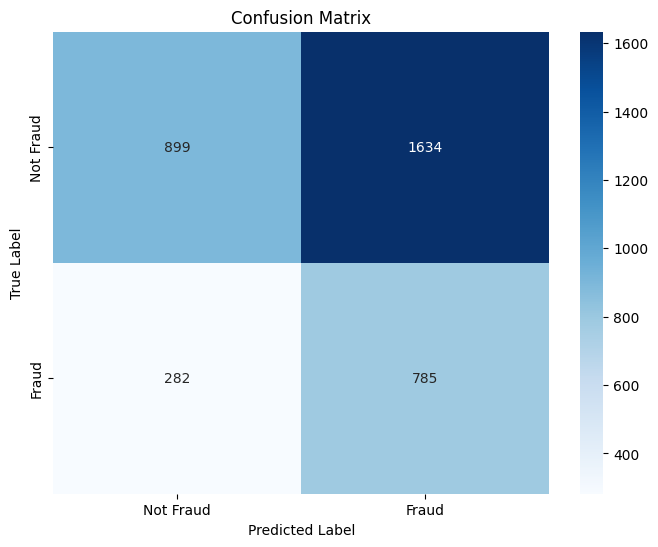


Evaluation Metrics:
Accuracy: 0.4678
Precision: 0.3245
Recall: 0.7357
F1 Score: 0.4504


In [ ]:
labels, _ = predict_and_plot_matrix(sample_df, model, FEATURE_COLS_FHE)

In [ ]:
file_path = "/content/random_from_full.csv"

In [ ]:
test_df = pd.read_csv(file_path)

In [ ]:
sample_df_1 = test_df.head(1000)

In [ ]:
sample_df_2 = test_df.sample(8000, random_state=100)

In [ ]:
print(select_model_pipeline(preprocess_fhe_style(sample_df_1)))

>> Running CPU preprocessing (FHE-style)...
>> CPU preprocessing done. Final columns: ['bank_id', 'Timestamp', 'From Bank', 'From_Account', 'To Bank', 'To_Account', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering', 'Sender_Bank Name', 'Sender_Bank ID', 'Sender_Entity ID', 'Sender_Entity Name', 'Receiver_Bank Name', 'Receiver_Bank ID', 'Receiver_Entity ID', 'Receiver_Entity Name', 'Bank_Partition', 'Hour', 'DayOfWeek', 'Month', 'Day', 'IsWeekend', 'IsNightTime', 'Same_Bank', 'Same_Account', 'Same_Entity', 'Log_Amount_Received', 'Log_Amount_Paid', 'Amount_Difference', 'Round_Amount_Received', 'Round_Amount_Paid', 'Below_Threshold', 'Currency_Mismatch', 'Payment Format_Encoded', 'Receiving Currency_Encoded', 'Payment Currency_Encoded']
========== MODEL PIPELINE RECOMMENDATION ==========
Rows: 1,000, Columns: 40
Unique banks: 473, Currencies: 15
Avg Amount: 9,884,461.87, StdDev: 262,708,088.19
Feature richness: 10, Sensitive cols

/tmp/ipython-input-447994984.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y/%m/%d %H:%M', errors='coerce')
/tmp/ipython-input-447994984.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Timestamp'].dt.hour.fillna(0).astype(int)
/tmp/ipython-input-447994984.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [ ]:
print(select_model_pipeline(preprocess_fhe_style(sample_df_2)))

>> Running CPU preprocessing (FHE-style)...
>> CPU preprocessing done. Final columns: ['bank_id', 'Timestamp', 'From Bank', 'From_Account', 'To Bank', 'To_Account', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering', 'Sender_Bank Name', 'Sender_Bank ID', 'Sender_Entity ID', 'Sender_Entity Name', 'Receiver_Bank Name', 'Receiver_Bank ID', 'Receiver_Entity ID', 'Receiver_Entity Name', 'Bank_Partition', 'Hour', 'DayOfWeek', 'Month', 'Day', 'IsWeekend', 'IsNightTime', 'Same_Bank', 'Same_Account', 'Same_Entity', 'Log_Amount_Received', 'Log_Amount_Paid', 'Amount_Difference', 'Round_Amount_Received', 'Round_Amount_Paid', 'Below_Threshold', 'Currency_Mismatch', 'Payment Format_Encoded', 'Receiving Currency_Encoded', 'Payment Currency_Encoded']
========== MODEL PIPELINE RECOMMENDATION ==========
Rows: 8,000, Columns: 40
Unique banks: 1497, Currencies: 15
Avg Amount: 2,908,992.33, StdDev: 102,347,217.69
Feature richness: 10, Sensitive col

>> Running CPU preprocessing (FHE-style)...
>> Running CPU preprocessing (FHE-style)...
>> CPU preprocessing done. Final columns: ['bank_id', 'Timestamp', 'From Bank', 'From_Account', 'To Bank', 'To_Account', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering', 'Sender_Bank Name', 'Sender_Bank ID', 'Sender_Entity ID', 'Sender_Entity Name', 'Receiver_Bank Name', 'Receiver_Bank ID', 'Receiver_Entity ID', 'Receiver_Entity Name', 'Bank_Partition', 'Hour', 'DayOfWeek', 'Month', 'Day', 'IsWeekend', 'IsNightTime', 'Same_Bank', 'Same_Account', 'Same_Entity', 'Log_Amount_Received', 'Log_Amount_Paid', 'Amount_Difference', 'Round_Amount_Received', 'Round_Amount_Paid', 'Below_Threshold', 'Currency_Mismatch', 'Payment Format_Encoded', 'Receiving Currency_Encoded', 'Payment Currency_Encoded']
>> CPU preprocessing done.
>> Preprocessing done. Final columns: ['bank_id', 'Timestamp', 'From Bank', 'From_Account', 'To Bank', 'To_Account', 'Amount 

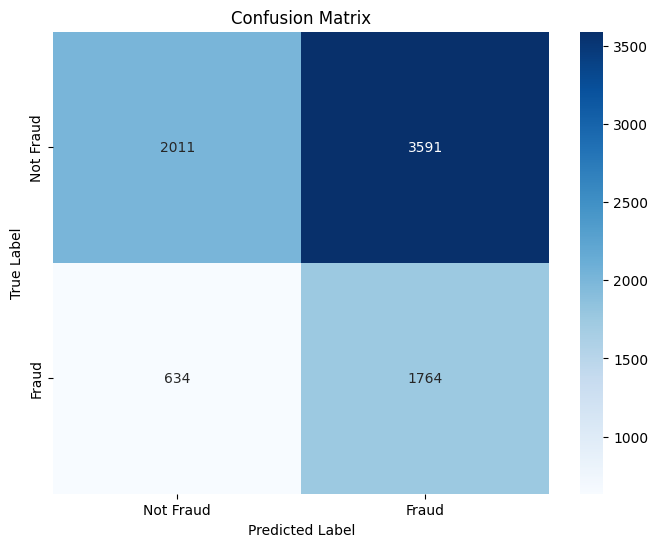


Evaluation Metrics:
Accuracy: 0.4719
Precision: 0.3294
Recall: 0.7356
F1 Score: 0.4550


In [ ]:
_, _ = predict_and_plot_matrix(sample_df_2, model, FEATURE_COLS_FHE)

>> Running CPU preprocessing (FHE-style)...
>> Running CPU preprocessing (FHE-style)...
>> CPU preprocessing done. Final columns: ['bank_id', 'Timestamp', 'From Bank', 'From_Account', 'To Bank', 'To_Account', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering', 'Sender_Bank Name', 'Sender_Bank ID', 'Sender_Entity ID', 'Sender_Entity Name', 'Receiver_Bank Name', 'Receiver_Bank ID', 'Receiver_Entity ID', 'Receiver_Entity Name', 'Bank_Partition', 'Hour', 'DayOfWeek', 'Month', 'Day', 'IsWeekend', 'IsNightTime', 'Same_Bank', 'Same_Account', 'Same_Entity', 'Log_Amount_Received', 'Log_Amount_Paid', 'Amount_Difference', 'Round_Amount_Received', 'Round_Amount_Paid', 'Below_Threshold', 'Currency_Mismatch', 'Payment Format_Encoded', 'Receiving Currency_Encoded', 'Payment Currency_Encoded']
>> CPU preprocessing done.
>> Preprocessing done. Final columns: ['bank_id', 'Timestamp', 'From Bank', 'From_Account', 'To Bank', 'To_Account', 'Amount 

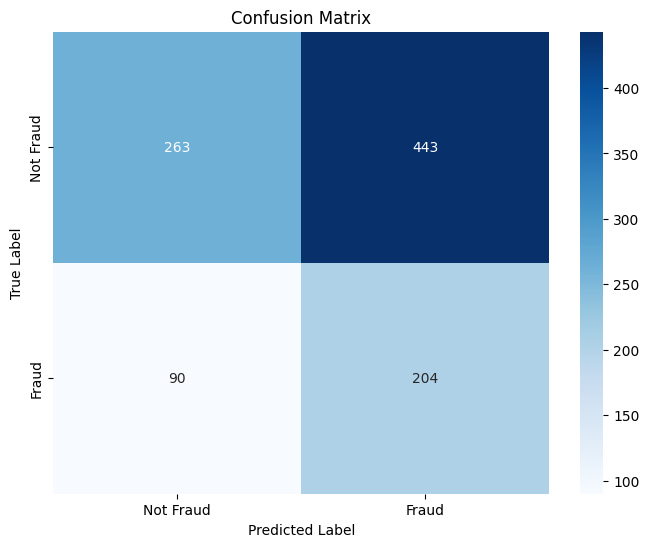


Evaluation Metrics:
Accuracy: 0.4670
Precision: 0.3153
Recall: 0.6939
F1 Score: 0.4336


In [ ]:
_, _ = predict_and_plot_matrix(sample_df_1, model, FEATURE_COLS_FHE)